In [1]:
import higlass as hg
import numpy as np
import pandas as pd
import bioframe
import cooltools
import cooler
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import os
from cooltools.lib.numutils import adaptive_coarsegrain
from cooltools.lib.plotting import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyBigWig
import numpy as np
import glob
import ast
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
sys.path.append('/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils/')

import utils_s as utils

### importing data, Hi-c maps 

In [2]:
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/10000')
res = 10_000

### CTCF & RAD21 tabels

In [10]:
# Path to the bigWig file
bw_path_rad21 = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_Rad21-ChIPseq.bw"
bw_path_ctcf = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw"

###importing ctcf peaks ####
ctcf_path='/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14'
ctcf = bioframe.read_table(ctcf_path+'/CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed', schema='bed')#.query(f'chrom in {clr.chromnames}')

### importing ctcf motifs ###
direct='/project/fudenber_735/motifs/mm10/jaspar/MA0139.1.tsv.gz'
motif=bioframe.read_table(direct)
motif=motif.rename(columns={0: 'chrom', 1: 'start',2:'end',3:'name',4:'score',5:'pval',6:'strand'})

### importing RAD21 
RAD21=bioframe.read_table(ctcf_path+'/RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed', schema='bed')#.query(f'chrom in {clr.chromnames}')
ctcf['mid']=(ctcf.end+ctcf.start)/2
RAD21['mid']=(RAD21.end+RAD21.start)/2

### overlap between peaks and motifs### 
peaks_motifs = bioframe.overlap(ctcf,motif,how='inner')
peaks_motifs=peaks_motifs.rename(columns={'strand':'strand_','strand_':'strand'})
peaks_motifs=peaks_motifs[['chrom','start','end','strand']]

# Paths to the bigWig files
bw_path_rad21 = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_Rad21-ChIPseq.bw"
bw_path_ctcf = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw"

bw_rad21 = pyBigWig.open(bw_path_rad21)
bw_ctcf = pyBigWig.open(bw_path_ctcf)






### visualizing the domain

/tmp/SLURM_24483152/ipykernel_12602/2778361806.py:7: RuntimeWarning: divide by zero encountered in log10
  im = plt.matshow(np.log10(cname),


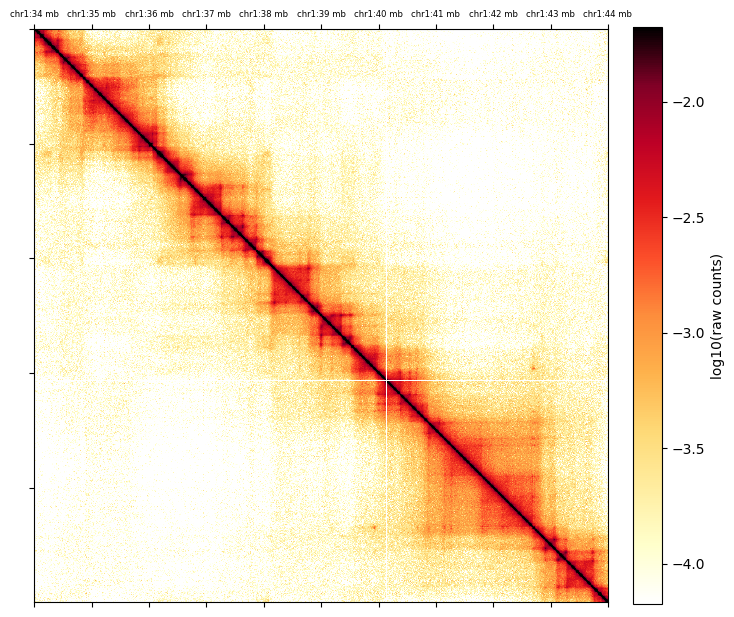

In [4]:
plt.figure(figsize=(8.1,8.10))

region = 'chr1:34000000-44000000'
region_start=bioframe.parse_region_string(region)[1]
cname = (cooler.Cooler(bonev_file+'::resolutions/'+str(res)).matrix(balance=True).fetch(region))

im = plt.matshow(np.log10(cname), 
                 vmax = np.log10(np.nanmedian(np.diag(cname,2))), 
                 vmin= np.log10(np.nanmedian(np.diag(cname,2)))-2.5, 
                 fignum=False ,cmap='fall' ); 
plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(raw counts)')
plt.xticks(utils.axes_ary(region)[0], fontsize = 6.1)
plt.gca().set_xticklabels(utils.axes_ary(region)[1])
plt.gca().set_yticklabels([])
plt.savefig('../outputs/chrdomain_%s.png'%region)
plt.show()

### importing simulations

In [6]:
path_dict_n = {}

directory = '/scratch1/rahmanin/Site_wise_occupancy/simulations/'
for name  in glob.glob(directory+'sims/chr6/folder_*'):
    path_dict_n[name.split('chr6/')[1][:]]= name
path_dict_n = dict(sorted(path_dict_n.items()))
len(path_dict_n)

1

In [7]:
name = name.split('chr6/')[1][:] 

/tmp/SLURM_24483152/ipykernel_12602/833189161.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(cname),


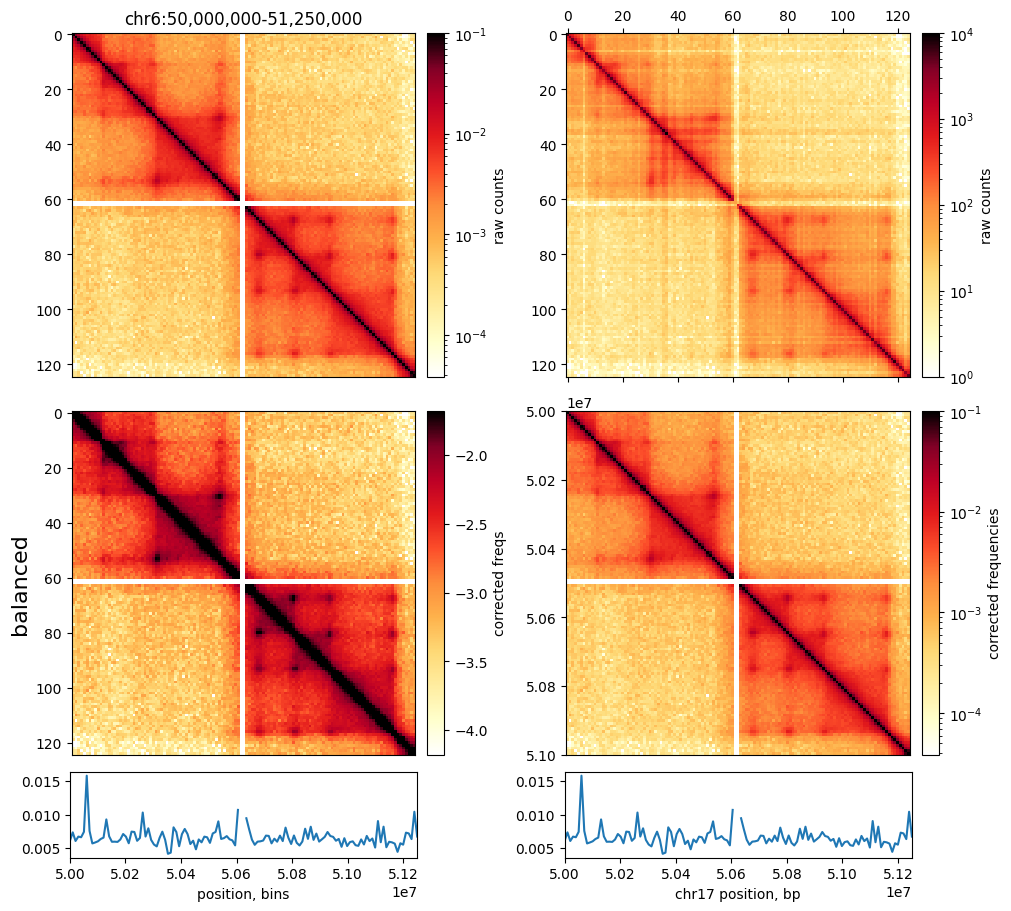

In [53]:
##### determine the region

region = "chr6:50000000-51250000"
region_ = bioframe.parse_region_string(region)
chrom = region_[0]
start_reg = region_[1]
end_reg = region_[2]


### layout for plot ###
plt_width=4
f, axs = plt.subplots(
    figsize=( plt_width+plt_width+2, plt_width+plt_width+1),
    ncols=4,
    nrows=3,
    gridspec_kw={'height_ratios':[4,4,1],"wspace":0.01,'width_ratios':[1,.05,1,.05]},
    constrained_layout=True
)

norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=1, vmax=10_000)

##### raw data
clr = cooler.Cooler(bonev_file + '::resolutions/' + str(res))
cname = clr.matrix(balance=True).fetch(region)
ax = axs[0,0]
im = ax.matshow(
    clr.matrix().fetch(region),
    norm=norm,
    cmap='fall',
);
ax.set_title(f'{chrom}:{start_reg:,}-{end_reg:,}')
ax.xaxis.set_visible(False)
ax.xaxis.set_visible(False)

cax = axs[0,1]
plt.colorbar(im, cax=cax, label='raw counts')

##### Balanced data
ax = axs[1,0]
im = ax.matshow(
    np.log10(cname),
    cmap='fall',
    vmax=np.log10(np.nanmedian(np.diag(cname, 2))),
    vmin=np.log10(np.nanmedian(np.diag(cname, 2))) - 2.5,
);
ax.xaxis.set_visible(False)
ax.set_ylabel('balanced', fontsize=16)

cax = axs[1,1]
plt.colorbar(im, cax=cax, label='corrected freqs')

ax1 = axs[2,0]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start_reg, end_reg, len(weights)),
    weights
)
ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('position, bins')

ax1 = axs[2,1]
ax1.set_visible(False)

##### simulated map 1d
ax = axs[0,2]
im = ax.matshow(
        clr.matrix(balance=False).fetch(region),
    norm=norm_raw,
    cmap='fall'
);


cax = axs[0,3]
plt.colorbar(im, cax=cax, label='raw counts');

##### simulated data 3d 
ax = axs[1,2]
im = ax.matshow(
    clr.matrix().fetch(region),
    norm=norm,
    cmap='fall',
    extent=(start, end, end, start)
);
ax.xaxis.set_visible(False)

cax = axs[1,3]
plt.colorbar(im, cax=cax, label='corrected frequencies');

ax1 = axs[2,2]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start_reg, end_reg, len(weights)),
    weights
)
#format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start_reg, end_reg);
ax1.set_xlabel('chr17 position, bp')

ax1 = axs[2,3]
ax1.set_visible(False)




### path to simulation

In [15]:
path_dict_n = {}

directory = '/scratch1/rahmanin/Site_wise_occupancy/simulations/'
for names  in glob.glob(directory+'sims/chr6/folder_*'):
    name = names.split('sims/chr6/')[1][:]
    path_dict_n[name]= names
path_dict_n = dict(sorted(path_dict_n.items()))
print(len(path_dict_n))
c = 1
lefs = h5py.File(path_dict_n[name]+'/LEFPositions.h5','r')["positions"]
chip = utils.chip_seq_from_lef(lefs, mapN)
with  h5py.File(path_dict_n[name]+'/LEFPositions.h5', mode='r') as myfile:
    lef_array = np.array(myfile['positions']) 
lef_array_snip = lef_array[:10]
m = utils.contact_map_from_lefs(lef_array[:],5000)
matrix = adaptive_coarsegrain(m+1, m+1, cutoff = 3, max_levels=3, min_shape = 2)
padded_matrix = np.pad(matrix, ((0, 1), (0, 1)), mode='constant')
binned_matrix = padded_matrix.reshape(100, 50, 100, 50).sum(axis=(1, 3))

1


/home1/rahmanin/.local/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


In [16]:
#flipped
path_dict_flipped = {}

directory = '/scratch1/rahmanin/Site_wise_occupancy/simulations/'
for names  in glob.glob(directory+'sims/folder_*'):
    name = names.split('sims/')[1][:]
    path_dict_flipped[name]= names
path_dict_flipped = dict(sorted(path_dict_flipped.items()))
print(len(path_dict_flipped))
lefs = h5py.File(path_dict_flipped[name]+'/LEFPositions.h5','r')["positions"]
chip_fliped = utils.chip_seq_from_lef(lefs, mapN)
with  h5py.File(path_dict_flipped[name]+'/LEFPositions.h5', mode='r') as myfile:
    lef_array = np.array(myfile['positions']) 
lef_array_snip = lef_array[:10]
m = utils.contact_map_from_lefs(lef_array[:],5000)
matrix = adaptive_coarsegrain(m+1, m+1, cutoff = 3, max_levels=3, min_shape = 2)
padded_matrix = np.pad(matrix, ((0, 1), (0, 1)), mode='constant')
binned_matrix_flipped = padded_matrix.reshape(100, 50, 100, 50).sum(axis=(1, 3))

1


In [6]:
params = [ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
mapN = mon*site
lattice_size = 0.25 # in kb

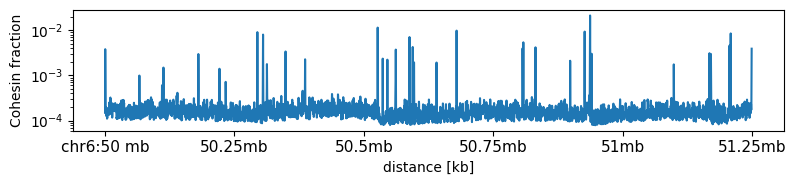

/home1/rahmanin/.local/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


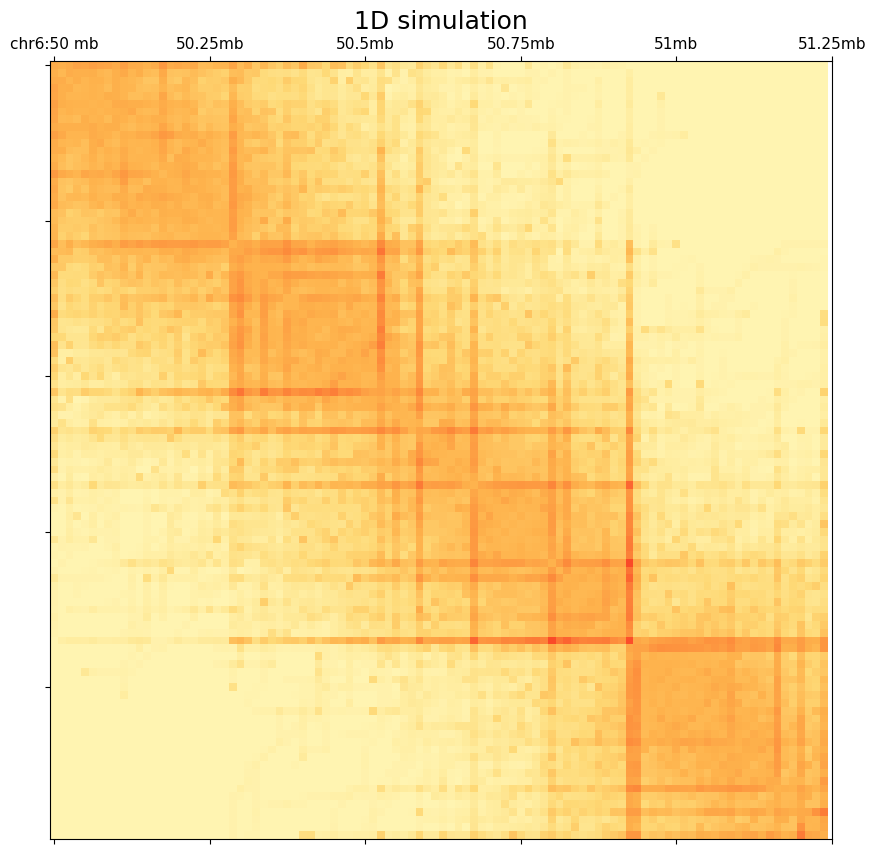

In [7]:
c = 1
for name in path_dict_n.keys():
    
    lefs = h5py.File(path_dict_n[name]+'/LEFPositions.h5','r')["positions"]
    chip = utils.chip_seq_from_lef(lefs, mapN)
    lattice_size = 0.25 # in kb
    plt.figure(figsize = (8.1,1.95))
    plt.plot(np.arange(len(chip))*lattice_size,chip/np.sum(chip), label=name)
    plt.xticks([0, 250, 500, 750, 1000, 1250],fontsize=11.1)
    plt.gca().set_xticklabels(['chr6:50 mb', '50.25mb', '50.5mb','50.75mb', '51mb','51.25mb'])
    plt.ylabel('Cohesin fraction')
    plt.yscale('log')
    plt.xlabel('distance [kb]')
    plt.tight_layout()
    plt.show()
    region = 'chr1:34000000-35250000'
    region = 'chr6:50000000-51250000'
    plt.figure(figsize=(10.1,10.1))    
    with  h5py.File(path_dict_n[name]+'/LEFPositions.h5', mode='r') as myfile:
        lef_array = np.array(myfile['positions']) 
    lef_array_snip = lef_array[:10]
    m = utils.contact_map_from_lefs(lef_array[:],5000)
    plt.title('1D simulation',fontsize=18) 
    new_m = adaptive_coarsegrain(m+1, m+1, cutoff = 3, max_levels=3, min_shape = 2)
    matrix = new_m
    padded_matrix = np.pad(matrix, ((0, 1), (0, 1)), mode='constant')
    binned_matrix = padded_matrix.reshape(100, 50, 100, 50).sum(axis=(1, 3))
    im = plt.matshow(np.log10(binned_matrix+1), vmax=8.1, vmin=2.5,cmap='fall', fignum=False)

    plt.xticks(utils.axes_ary(region)[0], fontsize = 6.1)
    plt.xticks([0, 20, 40, 60, 80, 100],fontsize=11.1)
    plt.gca().set_xticklabels(['chr6:50 mb', '50.25mb', '50.5mb','50.75mb', '51mb','51.25mb'])
    plt.gca().set_yticklabels([])
    plt.savefig('{region}.png'.format(region=region))
    plt.show()

/home1/rahmanin/.local/lib/python3.11/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


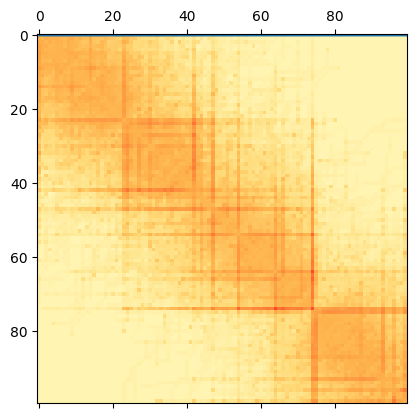

In [99]:
c = 1
for name in path_dict_n.keys():
    
    lefs = h5py.File(path_dict_n[name]+'/LEFPositions.h5','r')["positions"]
    chip = utils.chip_seq_from_lef(lefs, mapN)
    with  h5py.File(path_dict_n[name]+'/LEFPositions.h5', mode='r') as myfile:
        lef_array = np.array(myfile['positions']) 
    lef_array_snip = lef_array[:10]
    plt.plot(np.arange(len(chip))*lattice_size,chip/np.sum(chip), label=name)
    m = utils.contact_map_from_lefs(lef_array[:],5000)
    matrix = adaptive_coarsegrain(m+1, m+1, cutoff = 3, max_levels=3, min_shape = 2)
    padded_matrix = np.pad(matrix, ((0, 1), (0, 1)), mode='constant')
    binned_matrix = padded_matrix.reshape(100, 50, 100, 50).sum(axis=(1, 3))
    im = plt.matshow(np.log10(binned_matrix+1), vmax=8.1, vmin=2.5,cmap='fall', fignum=False)

In [104]:
path_dict_flipped[name]

'/scratch1/rahmanin/Site_wise_occupancy/simulations/sims/chr6/folder_face_1.0_back_0_Clife_150.0_Cof_150.0_life_660.0_slife_660.0_birth_0.1_pause_0.9_sep_75_site_10_monomer_500_replica_10_steps_175.0_vel_1'

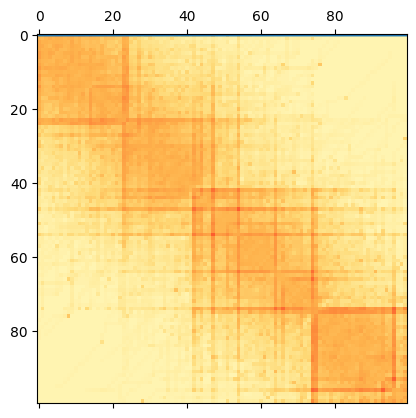

In [106]:
c = 1
for name in path_dict_flipped.keys():
    
    lefs = h5py.File(path_dict_flipped[name]+'/LEFPositions.h5','r')["positions"]
    chip_fliped = utils.chip_seq_from_lef(lefs, mapN)
    with  h5py.File(path_dict_flipped[name]+'/LEFPositions.h5', mode='r') as myfile:
        lef_array = np.array(myfile['positions']) 
    lef_array_snip = lef_array[:10]
    plt.plot(np.arange(len(chip))*lattice_size,chip/np.sum(chip), label=name)
    m = utils.contact_map_from_lefs(lef_array[:],5000)
    matrix = adaptive_coarsegrain(m+1, m+1, cutoff = 3, max_levels=3, min_shape = 2)
    padded_matrix = np.pad(matrix, ((0, 1), (0, 1)), mode='constant')
    binned_matrix_flipped = padded_matrix.reshape(100, 50, 100, 50).sum(axis=(1, 3))
    im = plt.matshow(np.log10(binned_matrix_flipped+1), vmax=8.1, vmin=2.5,cmap='fall', fignum=False)

/tmp/SLURM_24483152/ipykernel_1225/3483784697.py:44: RuntimeWarning: divide by zero encountered in log10
  np.log10(cname),


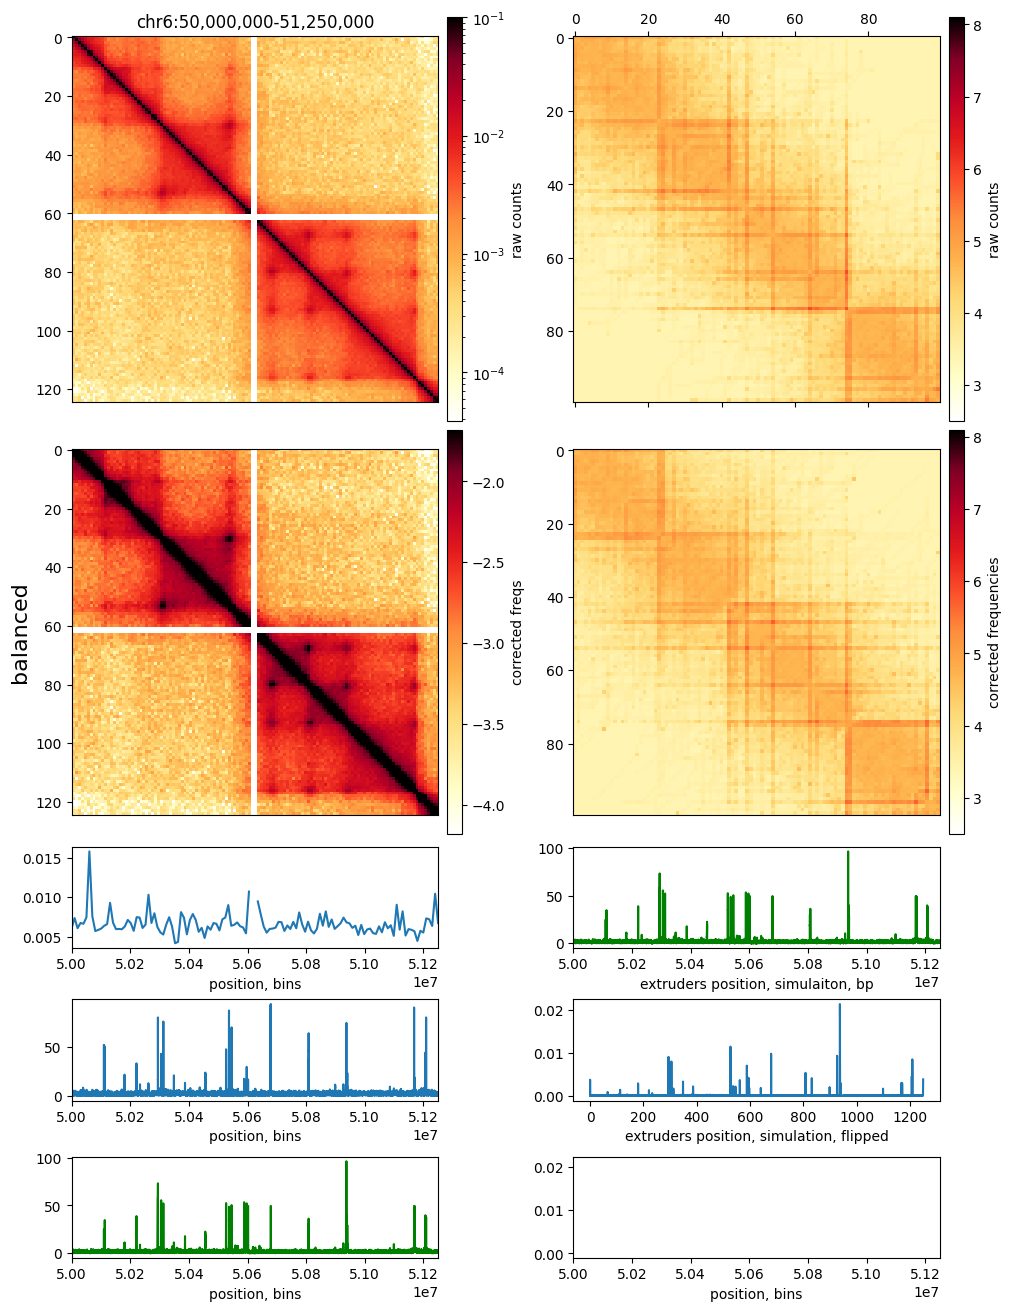

In [17]:
##### determine the region

region = "chr6:50000000-51250000"
region_ = bioframe.parse_region_string(region)
chrom = region_[0]
start_reg = region_[1]
end_reg = region_[2]

values_rad21 = np.nan_to_num(bw_rad21.values(chrom, start_reg, end_reg))
#bw_rad21.close()
values_ctcf = np.nan_to_num(bw_ctcf.values(chrom, start_reg, end_reg))
### layout for plot ###
plt_width=4
f, axs = plt.subplots(
    figsize=(plt_width + plt_width + 2, plt_width + plt_width + 5),
    ncols=4,
    nrows=5,
    gridspec_kw={'height_ratios':[4,4,1,1,1],"wspace":0.01,'width_ratios':[1,.04,1,.04]},
    constrained_layout=True
)

norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=1, vmax=10_000)

##### raw data
clr = cooler.Cooler(bonev_file + '::resolutions/' + str(res))
cname = clr.matrix(balance=True).fetch(region)
ax = axs[0,0]
im = ax.matshow(
    clr.matrix().fetch(region),
    norm=norm,
    cmap='fall',
);
ax.set_title(f'{chrom}:{start_reg:,}-{end_reg:,}')
ax.xaxis.set_visible(False)
ax.xaxis.set_visible(False)

cax = axs[0,1]
plt.colorbar(im, cax=cax, label='raw counts')

##### Balanced data
ax = axs[1,0]
im = ax.matshow(
    np.log10(cname),
    cmap='fall',
    vmax=np.log10(np.nanmedian(np.diag(cname, 2))),
    vmin=np.log10(np.nanmedian(np.diag(cname, 2))) - 2.5,
);
ax.xaxis.set_visible(False)
ax.set_ylabel('balanced', fontsize=16)

cax = axs[1,1]
plt.colorbar(im, cax=cax, label='corrected freqs')

ax1 = axs[2,0]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start_reg, end_reg, len(weights)),
    weights
)
ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('position, bins')

ax1 = axs[2,1]
ax1.set_visible(False)

ax1 = axs[3,0]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(
    np.arange(start_reg, end_reg), values_rad21,
#    weights
)
ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('position, bins')

ax1 = axs[3,1]
ax1.set_visible(False)

ax1 = axs[4,0]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(np.arange(start_reg, end_reg), values_ctcf, color='green', label='CTCF ChIP-seq')
ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('position, bins')

ax1 = axs[4,1]
ax1.set_visible(False)
#ax1.set_visible()
##### simulated map 1d
ax = axs[0,2]
#im = ax.matshow(
#        clr.matrix(balance=False).fetch(region),
#    norm=norm_raw,
#    cmap='fall'
#);
im = ax.matshow(np.log10(binned_matrix+1), vmax=8.1, vmin=2.5,cmap='fall')

cax = axs[0,3]
plt.colorbar(im, cax=cax, label='raw counts');

##### simulated data 3d 
ax = axs[1,2]
im = ax.matshow(np.log10(binned_matrix_flipped+1), vmax=8.1, vmin=2.5,cmap='fall');
ax.xaxis.set_visible(False)

cax = axs[1,3]
plt.colorbar(im, cax=cax, label='corrected frequencies');

ax1 = axs[2,2]
weights = clr.bins().fetch(region)['weight'].values

ax1.plot(np.arange(start_reg, end_reg), values_ctcf, color='green', label='CTCF ChIP-seq')
#format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start_reg, end_reg);
ax1.set_xlabel('extruders position, simulaiton, bp')

ax1 = axs[2,3]
ax1.set_visible(False)


ax1 = axs[3,2]
#ax1.plot(np.arange(start_reg, end_reg), values_rad21, color='blue', label='Rad21 ChIP-seq')
ax1.plot(np.arange(len(chip))*lattice_size,chip/np.sum(chip))
#ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('extruders position, simulation, flipped')

ax1 = axs[3,3]
ax1.set_visible(False)


ax1 = axs[4,2]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(np.arange(len(chip))*lattice_size,chip/np.sum(chip))
ax1.set_xlim([start_reg, end_reg])
ax1.set_xlabel('position, bins')

ax1 = axs[4,3]
ax1.set_visible(False)

/tmp/SLURM_24483152/ipykernel_12602/1715773969.py:69: RuntimeWarning: divide by zero encountered in log10
  np.log10(cname),


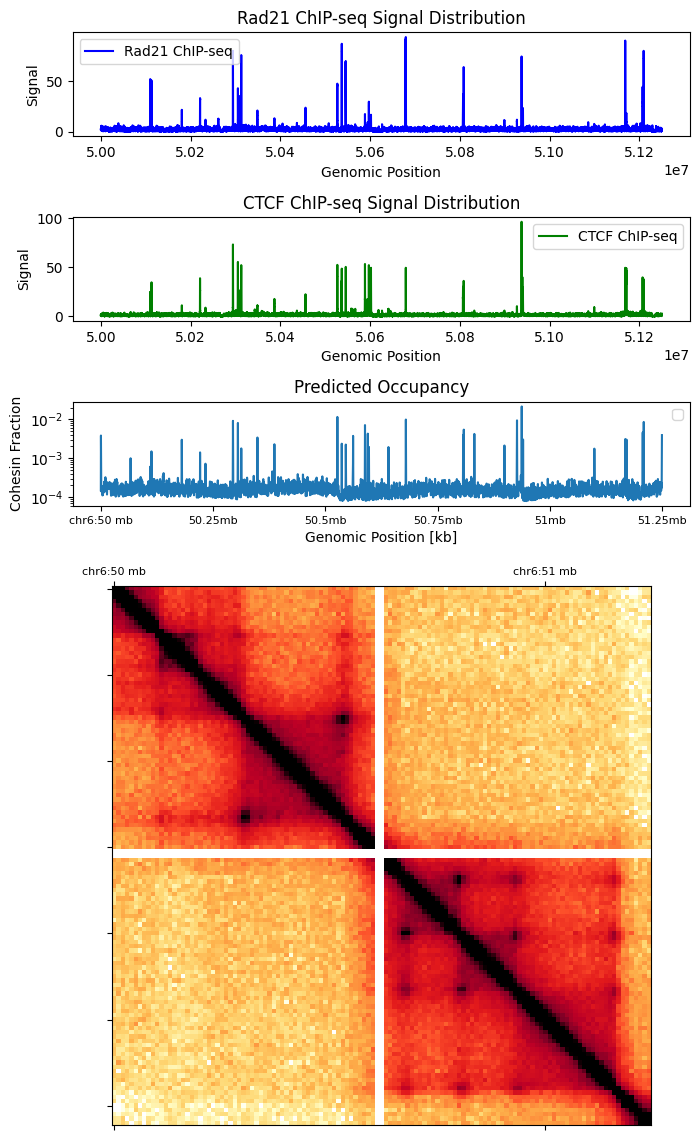

In [73]:
# Paths to the bigWig files
bw_path_rad21 = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_Rad21-ChIPseq.bw"
bw_path_ctcf = "/project/fudenber_735/GEO/justice_2020_GSE137272/mm10/GSE137272_CTCF-ChIPseq.bw"

# Define the region of interest (e.g., chr6:50,000,000-51,250,000)
chrom = "chr6"
start = 50000000
end = 51250000

# Setup the figure and gridspec
fig = plt.figure(figsize=(7.1, 11.5))  # Adjust the overall figure size
gs = gridspec.GridSpec(4, 1, height_ratios=[1] * (3) + [5.175])  # Last row larger

# Plot Rad21 ChIP-seq
ax_rad21 = fig.add_subplot(gs[0])
bw_rad21 = pyBigWig.open(bw_path_rad21)
values_rad21 = np.nan_to_num(bw_rad21.values(chrom, start, end))
bw_rad21.close()

ax_rad21.plot(np.arange(start, end), values_rad21, color='blue', label='Rad21 ChIP-seq')
ax_rad21.set_title("Rad21 ChIP-seq Signal Distribution")
ax_rad21.set_xlabel("Genomic Position")
ax_rad21.set_ylabel("Signal")
ax_rad21.legend()

# Plot CTCF ChIP-seq
ax_ctcf = fig.add_subplot(gs[1])
bw_ctcf = pyBigWig.open(bw_path_ctcf)
values_ctcf = np.nan_to_num(bw_ctcf.values(chrom, start, end))
bw_ctcf.close()

ax_ctcf.plot(np.arange(start, end), values_ctcf, color='green', label='CTCF ChIP-seq')
ax_ctcf.set_title("CTCF ChIP-seq Signal Distribution")
ax_ctcf.set_xlabel("Genomic Position")
ax_ctcf.set_ylabel("Signal")
ax_ctcf.legend()

# Plot Predicted Occupancy for Each Path in path_dict_n

ax = fig.add_subplot(gs[2])
params = [ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params

mapN = mon * site
lefs = h5py.File(path_dict_n[name] + '/LEFPositions.h5', 'r')["positions"]
chip = utils.chip_seq_from_lef(lefs, mapN)
lattice_size = 0.25  # in kb

ax.plot(np.arange(len(chip)) * lattice_size, chip / np.sum(chip))
ax.set_xticks([0, 250, 500, 750, 1000, 1250])
ax.set_xticklabels(['chr6:50 mb', '50.25mb', '50.5mb', '50.75mb', '51mb', '51.25mb'], fontsize=8)
ax.set_title("Predicted Occupancy")
ax.set_ylabel("Cohesin Fraction")
ax.set_yscale("log")
ax.set_xlabel("Genomic Position [kb]")
ax.legend()

# Plot Hi-C Map
region = "chr6:50000000-51250000"
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/10000')
res = 10_000


ax_hic = fig.add_subplot(gs[3])  # Last subplot for Hi-C map
cname = cooler.Cooler(bonev_file + '::resolutions/' + str(res)).matrix(balance=True).fetch(region)

im = ax_hic.matshow(
    np.log10(cname),
    vmax=np.log10(np.nanmedian(np.diag(cname, 2))),
    vmin=np.log10(np.nanmedian(np.diag(cname, 2))) - 2.5,
    cmap="fall",
)
#plt.colorbar(im, ax=ax_hic, fraction=0.046, pad=0.04, label="log10(raw counts)")
ax_hic.set_xticks(utils.axes_ary(region)[0])
ax_hic.set_xticklabels(utils.axes_ary(region)[1], fontsize=8)
ax_hic.set_yticklabels([])

# Save all the plots to a single PNG file
plt.tight_layout()
plt.savefig("combined_plots_with_hic.png", dpi=300, bbox_inches="tight")
plt.show()


In [31]:
region_ctcf_motif = utils.region_data_frame(peaks_motifs, region = 'chr1:34000000-35000000')

/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['mid']=(region_dataframe.end+region_dataframe.start)/2
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['lattice_loc'] = ((region_dataframe['mid'] - region_start) // lattice_size).astype('int')


In [36]:
region = 'chr1:34000000-34100000'
df1 = utils.region_data_frame(ctcf, region = region)
df2 = utils.region_data_frame(motif, region = region)
overlapping_intervals = bioframe.overlap(df1, df2, how='inner', suffixes=('_1','_2'))
display(overlapping_intervals)


/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['mid']=(region_dataframe.end+region_dataframe.start)/2
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['lattice_loc'] = ((region_dataframe['mid'] - region_start) // lattice_size).astype('int')
/home1/rahmanin/start/polychrom/projects/Site_wise_occu

,chrom_1,start_1,end_1,name_1,score_1,strand_1,mid_1,lattice_loc_1,chrom_2,start_2,end_2,name_2,score_2,pval_2,strand_2,mid_2,lattice_loc_2
0,chr1,34005641,34006016,CTCF_4reps_peak_406,57.35360,NaN,34005828.5,23,chr1,34005817,34005836,CTCF,810,403,+,34005826.5,23
1,chr1,34011003,34011576,CTCF_4reps_peak_407,81.03111,NaN,34011289.5,45,chr1,34011254,34011273,CTCF,824,430,+,34011263.5,45
2,chr1,34049624,34049965,CTCF_4reps_peak_408,17.84861,NaN,34049794.5,199,chr1,34049802,34049821,CTCF,901,607,-,34049811.5,199
3,chr1,34068201,34068742,CTCF_4reps_peak_411,111.66768,NaN,34068471.5,273,chr1,34068515,34068534,CTCF,925,680,-,34068524.5,274
4,chr1,34093645,34094093,CTCF_4reps_peak_412,95.51875,NaN,34093869.0,375,chr1,34093844,34093863,CTCF,800,386,+,34093853.5,375


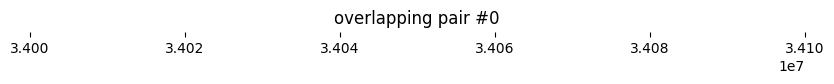

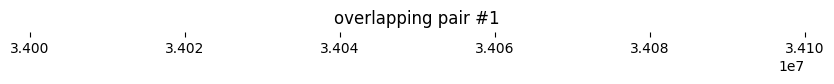

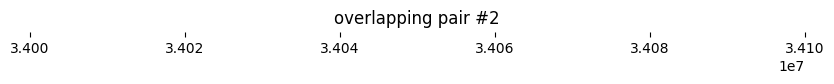

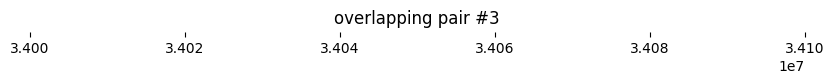

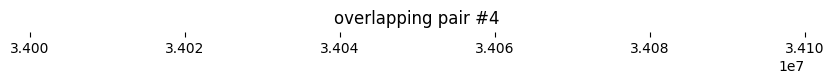

In [40]:
for i, reg_pair in overlapping_intervals.iterrows():
    bioframe.vis.plot_intervals_arr(
        starts = [reg_pair.start_1,reg_pair.start_2],
        ends = [reg_pair.end_1,reg_pair.end_2],
        colors = ['skyblue', 'lightpink'],
        levels = [2,1],
        xlim = (34000000,34100000),
        show_coords = True)
    plt.title(f'overlapping pair #{i}')

### creating ctcf table

In [23]:
region = 'chr1:34000000-44000000'


In [19]:
region_ctcf_motif = utils.region_data_frame(peaks_motifs, region = 'chr1:34000000-44000000')
region_ = bioframe.parse_region_string('chr1:34000000-44000000')
region_ctcf_motif.to_csv('{name}_{begin}_{end}.csv'.format(name = region_[0], begin = region_[1], end = region_[2]) ,index=False)
region_ctcf_motif

/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['mid']=(region_dataframe.end+region_dataframe.start)/2
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['lattice_loc'] = ((region_dataframe['mid'] - region_start) // lattice_size).astype('int')


,chrom,start,end,strand,mid,lattice_loc
0,chr1,34005641,34006016,+,34005828.5,23
1,chr1,34011003,34011576,+,34011289.5,45
2,chr1,34049624,34049965,-,34049794.5,199
3,chr1,34068201,34068742,-,34068471.5,273
4,chr1,34093645,34094093,+,34093869.0,375
...,...,...,...,...,...,...
268,chr1,43738188,43738540,-,43738364.0,38953
269,chr1,43760145,43760509,+,43760327.0,39041
270,chr1,43762617,43762972,-,43762794.5,39051
271,chr1,43898949,43899413,+,43899181.0,39596


In [20]:
region_ctcf_motif = utils.region_data_frame(peaks_motifs, region = 'chr6:50000000-54000000')
region_ = bioframe.parse_region_string('chr6:50000000-54000000')
region_ctcf_motif.to_csv('{name}_{begin}_{end}.csv'.format(name = region_[0], begin = region_[1], end = region_[2]) ,index=False)
region_ctcf_motif

/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['mid']=(region_dataframe.end+region_dataframe.start)/2
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccupancyInputCTCF/utils.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_dataframe['lattice_loc'] = ((region_dataframe['mid'] - region_start) // lattice_size).astype('int')


,chrom,start,end,strand,mid,lattice_loc
0,chr6,50066186,50066527,+,50066356.5,265
1,chr6,50109867,50110506,-,50110186.5,440
2,chr6,50109867,50110506,-,50110186.5,440
3,chr6,50112734,50113150,+,50112942.0,451
4,chr6,50180221,50180611,-,50180416.0,721
...,...,...,...,...,...,...
135,chr6,53958374,53958858,+,53958616.0,15834
136,chr6,53961954,53962439,-,53962196.5,15848
137,chr6,53968504,53968872,+,53968688.0,15874
138,chr6,53982680,53983085,+,53982882.5,15931


### processing for simulaiton

In [3]:
input_file = 'data/chr1_34mb_44mb_with_predicted_occupancy.csv'
df = pd.read_csv(input_file)
df = df.query('lattice_loc<=10000')
df

,chrom,start,end,mid,strand,lattice_loc,predicted_occupancy
0,chr1,34005641,34006016,34005828.5,+,23,0.089047
1,chr1,34011003,34011576,34011289.5,+,45,0.220059
2,chr1,34049624,34049965,34049794.5,-,199,0.260436
3,chr1,34068201,34068742,34068471.5,-,273,0.644597
4,chr1,34093645,34094093,34093869.0,+,375,0.197648
...,...,...,...,...,...,...,...
63,chr1,36321730,36322172,36321951.0,-,9287,0.180413
64,chr1,36324025,36324431,36324228.0,+,9296,0.257837
65,chr1,36454412,36454833,36454622.5,+,9818,0.277825
66,chr1,36471503,36472006,36471754.5,-,9887,0.090944


In [4]:
dataframe = utils.make_region_occupancy(input_file)
target_dataframe = dataframe.query('lattice_loc<=10000')
target_dataframe

,chrom,start,end,mid,strand,lattice_loc,predicted_occupancy
0,chr1,34005641,34006016,34005828.5,+,23,0.089047
1,chr1,34011003,34011576,34011289.5,+,45,0.220059
2,chr1,34049624,34049965,34049794.5,-,199,0.260436
3,chr1,34068201,34068742,34068471.5,-,273,0.644597
4,chr1,34093645,34094093,34093869.0,+,375,0.197648
...,...,...,...,...,...,...,...
234,chr1,43738188,43738540,43738364.0,-,38953,0.254767
235,chr1,43760145,43760509,43760327.0,+,39041,0.337179
236,chr1,43762617,43762972,43762794.5,-,39051,0.163237
237,chr1,43898949,43899413,43899181.0,+,39596,0.288898


In [11]:
target_dataframe

,chrom,start,end,mid,strand,lattice_loc,predicted_occupancy
0,chr1,34005641,34006016,34005828.5,+,23,0.089047
1,chr1,34011003,34011576,34011289.5,+,45,0.220059
2,chr1,34049624,34049965,34049794.5,-,199,0.260436
3,chr1,34068201,34068742,34068471.5,-,273,0.644597
4,chr1,34093645,34094093,34093869.0,+,375,0.197648
...,...,...,...,...,...,...,...
56,chr1,36321730,36322172,36321951.0,-,9287,0.180413
57,chr1,36324025,36324431,36324228.0,+,9296,0.257837
58,chr1,36454412,36454833,36454622.5,+,9818,0.277825
59,chr1,36471503,36472006,36471754.5,-,9887,0.090944


### making ctcf sites

In [13]:
ctcfleftposition = list(target_dataframe[target_dataframe['strand']=='+']['lattice_loc'])
ctcfrightposition = list(target_dataframe[target_dataframe['strand']=='-']['lattice_loc'])
print(ctcfleftposition,ctcfrightposition)

[23, 45, 375, 760, 806, 874, 1852, 1944, 2045, 2053, 2165, 2336, 2570, 2954, 3106, 3167, 3469, 3567, 4131, 5067, 5553, 5570, 6907, 7063, 7358, 8581, 8899, 9025, 9296, 9818] [199, 273, 659, 1164, 1640, 1944, 2064, 2336, 2410, 2803, 3102, 3469, 3588, 3648, 5067, 5542, 5861, 5913, 6864, 7387, 8041, 8260, 8539, 8598, 9012, 9019, 9109, 9117, 9287, 9887, 9970]
